<a href="https://colab.research.google.com/github/tatiana-ka/movie-plot-text-clustering-topic-modeling/blob/main/movies_up2_2012_prep_n_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Set-up**

In [ ]:
from google.colab import files, drive #connecting to my google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import re
import ast
import spacy
import nltk
import scipy.stats

### **Initial Data Prep**

The movie plot data is from http://www.cs.cmu.edu/~ark/personas/. There you can download a couple of files. The ones I am interested in are Movie metadata and Plot summary. I am going to ignire the information about characters and actors (Character metadata) file. 

Since I would like to investigate the plot originality in relation to movie success, I need to merge the two files (Movie metadata and Plot summary). 

**1. Loading Meta Data**

In [ ]:
meta = pd.read_csv('/content/drive/MyDrive/movies2012data/movie.metadata.tsv', sep = '\t', header = None)

meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

0. Wikipedia movie ID
1. Freebase movie ID
2. Movie name
3. Movie release date
4. Movie box office revenue
5. Movie runtime
6. Movie languages (Freebase ID:name tuples)
7. Movie countries (Freebase ID:name tuples)
8. Movie genres (Freebase ID:name tuples)

In [ ]:
meta = meta.rename(columns= {0: 'wiki_movieID',
                             2: 'movie_name',
                             3: 'release_date',
                             4: 'box_of_rev',
                             5: 'run_time',
                             6: 'languages',
                             7: 'countries',
                             8: 'genres'}) #rename columns

In [ ]:
meta = meta.drop(columns=1) # drop FreebaseID

In [ ]:
meta.head()

,wiki_movieID,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


**2. Loading Plots**

In [ ]:
plot = pd.read_csv('/content/drive/MyDrive/movies2012data/plot_summaries.txt', delimiter= '\t', header = None)

plot.head()

,0,1
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Based on the data description, plot summaries of 42,303 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [ ]:
plot = plot.rename(columns={0:'wiki_movieID', 
                            1: 'summary'}) #renaming columns

**3. Merging the two dfs**

In [ ]:
merged = plot.merge(meta, on = 'wiki_movieID', how = 'left')

In [ ]:
merged.head()

,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


**4. Saving**

In [ ]:
merged.to_csv('merged_movies_df.csv')

!cp merged_movies_df.csv "/content/drive/MyDrive/movies2012data"

##### **5. A quick initial peek into the data**

In [ ]:
len(merged)

42303

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42303 entries, 0 to 42302
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wiki_movieID  42303 non-null  int64  
 1   summary       42303 non-null  object 
 2   movie_name    42204 non-null  object 
 3   release_date  39586 non-null  object 
 4   box_of_rev    7587 non-null   float64
 5   run_time      35580 non-null  float64
 6   languages     42204 non-null  object 
 7   countries     42204 non-null  object 
 8   genres        42204 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.2+ MB


Looks like I have box office information for 7587 movies only. That's not great, would be nice to have more movies, but speeds up the analysis. Which is good, since this is proof of concept. 

In [ ]:
columns = merged.columns

missing_count = []

for col in columns:
  missing_count.append(merged[col].isna().sum())

missing_summary = pd.DataFrame({'columns': columns,
                                'missing_coumnt': missing_count})

missing_summary  

,columns,missing_coumnt
0,wiki_movieID,0
1,summary,0
2,movie_name,99
3,release_date,2717
4,box_of_rev,34716
5,run_time,6723
6,languages,99
7,countries,99
8,genres,99


Now just a quick look into the summry of the plot. 

In [ ]:
merged.summary[0]

"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."

In [ ]:
len(merged.summary[0])

178

The first one seems to be quite short. I hope to have longer summaries. Such short ones probably do not demonstrate much of originality of the actual movie. 
If I needed short descriptions of the movies, I could have gone for summaries from IMDb.

Now need to check if this is an exception, or all the plots are these short. 

In [ ]:
summary_length = []

for i in range(len(merged)):
  summary_length.append(len(merged.summary[i]))

summary_length = np.array(summary_length)

print('Mean summary character length: ' + str(round(np.mean(summary_length),2)))
print('Max summary character length: ' + str(np.max(summary_length)))
print('Min summary character length: ' + str(np.min(summary_length)))

Mean summary character length: 1784.03
Max summary character length: 28159
Min summary character length: 99


Ok, looks like on average the plots are 10 times longer than the first plot I checked above. 

### **Data Cleaning**

In this section I clean and check some of the variables of potential interest:

1. Check the box office variable. That would be a measure of success. 
2. Check and create dummies for:
    * language
    * country
    * genre
3. Extract only year from release date.
4. Allign data formats.

In [ ]:
movie1 = pd.read_csv('/content/drive/MyDrive/movies2012data/merged_movies_df.csv')

movie1.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


#### **1. Explore the Key variable (DV) - Box Office**

In [ ]:
print('Missing box office' + str(movie1.box_of_rev.isna().sum()/len(movie1)))
print('Box office info available for ' + str(movie1.box_of_rev.notna().sum()) + ' movies')

Missing box office0.8206510176583222
Box office info available for 7587 movies


Only 18% of data (7587 movies) have box office info. Will keep only those

In [ ]:
movie2 = movie1[movie1.box_of_rev.notna()] #subsetting to keep only those with box office known

In [ ]:
movie2.describe()

,Unnamed: 0,wiki_movieID,box_of_rev,run_time
count,7587.000000,7.587000e+03,7.587000e+03,7513.000000
mean,21350.236853,8.622736e+06,5.175973e+07,106.030574
std,12125.625067,9.949717e+06,1.167179e+08,22.785962
min,1.000000,3.217000e+03,1.020000e+04,10.000000
25%,11054.000000,1.134646e+06,2.500000e+06,93.000000
50%,21472.000000,3.723947e+06,1.242118e+07,103.000000
75%,31751.000000,1.393558e+07,4.559722e+07,115.000000
max,42296.000000,3.695679e+07,2.782275e+09,1003.000000


In [ ]:
print('Max box office: ' + str(movie2.box_of_rev.max()))
print('Min box office: ' + str(movie2.box_of_rev.min()))

Max box office: 2782275172.0
Min box office: 10200.0


The range does not promice a normal distribution on this one. 

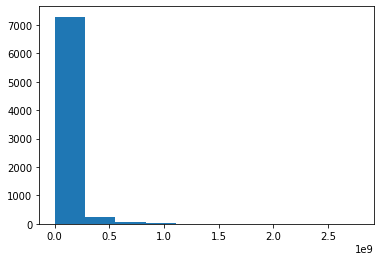

In [ ]:
plt.hist(movie2.box_of_rev)
plt.show()

Digging deeper into what's behind this bar:

In [ ]:
movie2.box_of_rev.quantile(0.5)

12421181.0

In [ ]:
movie2.box_of_rev.quantile(0.25)

2500000.0

In [ ]:
movie2.box_of_rev.quantile(0.75)

45597223.0

(array([2529.,  807.,  581.,  448.,  358.,  243.,  220.,  194.,  172.,
         138.]),
 array([1.02000000e+04, 4.56758360e+06, 9.12496720e+06, 1.36823508e+07,
        1.82397344e+07, 2.27971180e+07, 2.73545016e+07, 3.19118852e+07,
        3.64692688e+07, 4.10266524e+07, 4.55840360e+07]),
 <a list of 10 Patch objects>)

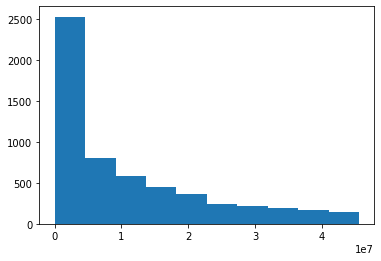

In [ ]:
plt.hist(movie2[movie2.box_of_rev <= movie2.box_of_rev.quantile(0.75)].box_of_rev)

(array([1197.,  679.,  435.,  307.,  251.,  228.,  183.,  154.,  197.,
         163.]),
 array([1.02000000e+04, 1.25129810e+06, 2.49239620e+06, 3.73349430e+06,
        4.97459240e+06, 6.21569050e+06, 7.45678860e+06, 8.69788670e+06,
        9.93898480e+06, 1.11800829e+07, 1.24211810e+07]),
 <a list of 10 Patch objects>)

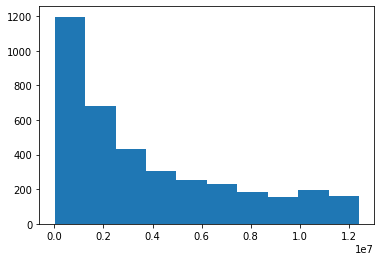

In [ ]:
plt.hist(movie2[movie2.box_of_rev <= movie2.box_of_rev.quantile(0.50)].box_of_rev)

(array([ 111.,  193.,  299.,  767., 1331., 1702., 1686., 1101.,  362.,
          35.]),
 array([ 9.230143  , 10.48178218, 11.73342137, 12.98506055, 14.23669973,
        15.48833892, 16.7399781 , 17.99161729, 19.24325647, 20.49489565,
        21.74653484]),
 <a list of 10 Patch objects>)

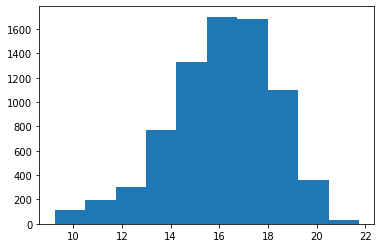

In [ ]:
plt.hist(np.log(movie2.box_of_rev)) # turns into a desent distribution with log trasformation

Log-transformation seems to do the trick nicely. So digging into funky distributions won't be necessary on this one. 

**2. Exploring the rest of the variables**

Exploration for further decitions about the data preparation

In [ ]:
movie2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7587 entries, 1 to 42296
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    7587 non-null   int64  
 1   wiki_movieID  7587 non-null   int64  
 2   summary       7587 non-null   object 
 3   movie_name    7587 non-null   object 
 4   release_date  7530 non-null   object 
 5   box_of_rev    7587 non-null   float64
 6   run_time      7513 non-null   float64
 7   languages     7587 non-null   object 
 8   countries     7587 non-null   object 
 9   genres        7587 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 652.0+ KB


Some missing values in *Release Date* and *Run Time*.
For simplisicty will drop all NAs for now. Can rerun the analysis including these movie plots later on. 

In [ ]:
movie3 = movie2.dropna(axis = 0).copy().reset_index(drop = True)

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama..."
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}"


#### **3. Reformating data into more informative variables**

 *Languages, Coutries, Genres* are a bit messy and need cleaning up. 

##### Language

In [ ]:
movie3['language_wo'] = movie3.languages.str.replace('[^\w]', ' ').str.strip() #create new column and strip language column of characters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language


In [ ]:
lang_list = list(movie3.language_wo) #convert into a list
lang_list1 = ' '.join(lang_list)#make into one item
lang_list1

'm 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 01wgr    Czech Language     m 06b_j    Russian Language     m 04306rv    German Language     m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language     m 06nm1    Spanish Language m 02h40lc    English Language m 0653m    Standard Mandarin m 03_9r    Japanese Language     m 02hwhyv    Korean Language     m 03115z    Mandarin Chinese m 02h40lc    English Language     m 0cjk9    Ukrainian Language     m 02hwyss    Turkish Language     m 02hxcvy    Urdu Language     m 06b_j    Russian Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 06b_j    Russian Language m 064_8sq    French Language     m 05qqm    Polis

In [ ]:
lang_list2  = re.sub('\s{3}', '', lang_list1) #remove excessive white spaces
lang_list2

'm 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 01wgr Czech Language  m 06b_j Russian Language  m 04306rv German Language  m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language  m 06nm1 Spanish Language m 02h40lc English Language m 0653m Standard Mandarin m 03_9r Japanese Language  m 02hwhyv Korean Language  m 03115z Mandarin Chinese m 02h40lc English Language  m 0cjk9 Ukrainian Language  m 02hwyss Turkish Language  m 02hxcvy Urdu Language  m 06b_j Russian Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 06b_j Russian Language m 064_8sq French Language  m 05qqm Polish Language  m 06b_j Russian Language  m 04306rv German Language  m 02h40lc English Language m 03_9r Japanese Language m 02h40lc Engl

In [ ]:
lang_list3 = lang_list2.split(' ')#turn back into a list
lang_list3 = np.array(lang_list3) #convert into numpy array
unique, couts = np.unique(lang_list3, return_counts = True) #get unique words and their frequency

Now will create unique "words" table out of what I have in languages. 

In [ ]:
language_df = pd.DataFrame({'uniques': unique,
                            'counts': couts}) # make a df out of it

language_df.sort_values('counts', ascending=False).head(10)

,uniques,counts
290,m,9794
208,Language,9332
175,English,6729
41,02h40lc,6689
0,,2722
89,064_8sq,490
182,French,490
97,06nm1,412
262,Spanish,412
187,German,257


Drop the ones that have digits in them, those are not language names.

In [ ]:
digit = []
for i in range(len(language_df)):
  digit.append(bool(re.match(r'[a-z]*\d[a-z]*',language_df.uniques[i])))  

In [ ]:
digit2 = np.array(digit) == False # turn the bollean the other way around

In [ ]:
language_df2 = language_df[digit2].copy()
language_df2.head()

,uniques,counts
0,,2722
143,Aboriginal,1
144,Afrikaans,8
145,Albanian,2
146,Algonquin,1


In [ ]:
language_df2.sort_values('counts', ascending=False).head(10)

,uniques,counts
290,m,9794
208,Language,9332
175,English,6729
0,,2722
182,French,490
262,Spanish,412
187,German,257
204,Korean,243
199,Italian,222
200,Japanese,204


In [ ]:
language_df2.drop([0, 208, 290, 288, 289, 287], axis = 0, inplace=True) #drop some odd words (e.g. m, langugae, etc)

In [ ]:
language_df2.sort_values('counts', ascending=False).head(10)

,uniques,counts
175,English,6729
182,French,490
262,Spanish,412
187,German,257
204,Korean,243
199,Italian,222
200,Japanese,204
244,Russian,175
263,Standard,134
215,Mandarin,128


In [ ]:
language_df3 = language_df2.sort_values('counts', ascending=False).reset_index(drop = True) # fix the df with frequency on descenting order
language_df3['cumulative'] = language_df3.counts.cumsum()/language_df3.counts.sum() #add a cumulative percentage column
language_df3.head() 

,uniques,counts,cumulative
0,English,6729,0.670019
1,French,490,0.718809
2,Spanish,412,0.759833
3,German,257,0.785423
4,Korean,243,0.809619


Unsurprisingly, almost 70% of the movies are in English. Can add this information as a dummy and decide later whether I only keep English language movies. 

In [ ]:
#create dummy for English
English_lang = []
for i in range(len(movie3)):
  English_lang.append(bool(re.match(r'.*English\s+.*',movie3.language_wo[i])))

In [ ]:
movie3['english_lang'] = English_lang

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo,english_lang
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language,True
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language,True
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language,True
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language,True
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language,True


*This was a rather bulcky approach. In the next section will try to use a different approach, i.e. capitalize on the fact that the string is structured like a python dictionary.* 

##### *Country*

In [ ]:
countries_listed = []

for i in range(len(movie3)):
  form_dic = ast.literal_eval(movie3.countries[i])#convert to dictionary
  form_list = list(form_dic.values())#extract values
  countries_listed.append(form_list)#paste values respective cell
  

In [ ]:
movie3.countries = countries_listed #substitute dictionaries with lists, lists are easier to search in

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo,english_lang
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language,True
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language,True
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Australia, New Zeal...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language,True
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language,True
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language,True


Now need to ideantify the top countries to see for shich of them I can create dummies. For that need to: 
* Flatten the list
* Turn in into numpy array
* Get unique values and their frequencies
* Turn the stats into df and get the top

In [ ]:
flat_list = []
for item in countries_listed:
  for country in item:
    flat_list.append(country)

flat_list = np.array(flat_list)

unique, counts = np.unique(flat_list, return_counts=True)


countries_df = pd.DataFrame({
    'countries': unique, 
    'counts': counts})

countries_df = countries_df.sort_values('counts', ascending=False).reset_index(drop = True)
countries_df['cumulative'] = countries_df.counts.cumsum()/countries_df.counts.sum() #get cumulative percentage

countries_df.head(10) #more than half belongs to the us, so we only need to create USA dummy

,countries,counts,cumulative
0,United States of America,6249,0.628103
1,United Kingdom,870,0.715549
2,France,446,0.760378
3,Germany,422,0.802794
4,Canada,300,0.832948
5,South Korea,264,0.859483
6,Japan,188,0.878380
7,Australia,158,0.894261
8,Italy,135,0.907830
9,Spain,90,0.916876


More than half of the movies are US., so I would only create the dummy to indicate that. 

In [ ]:
country_USA = []
for i in range(len(movie3)):
  country_USA.append('United States of America' in movie3.countries[i])

movie3['country_USA'] = country_USA 

movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo,english_lang,country_USA
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language,True,True
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language,True,True
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Australia, New Zeal...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language,True,True
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language,True,True
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language,True,True


##### *Genre*

Same approach like in Country. 

In [ ]:
genres_listed = []

for i in range(len(movie3)):
  form_dic = ast.literal_eval(movie3.genres[i])
  form_list = list(form_dic.values())#extract genre values
  genres_listed.append(form_list)

movie3.genres = genres_listed #substitute dictionaries with lists 

flat_list = []

for item in genres_listed:
  for g in item:
    flat_list.append(g)

flat_list = np.array(flat_list)

unique, counts = np.unique(flat_list, return_counts=True)

genres_df = pd.DataFrame({
    'genres': unique,
    'counts': counts
})

genres_df = genres_df.sort_values('counts', ascending=False).reset_index(drop = True)
genres_df['cumulative'] = genres_df.counts.cumsum()/genres_df.counts.sum()
genres_df.head(30)

,genres,counts,cumulative
0,Drama,3901,0.100355
1,Comedy,2927,0.175653
2,Thriller,1857,0.223426
3,Romance Film,1849,0.270992
4,Action,1640,0.313182
5,Action/Adventure,1284,0.346213
6,Crime Fiction,1179,0.376544
7,Adventure,1091,0.404610
8,Indie,941,0.428818
9,Romantic comedy,822,0.449964


To create dummies for Top 15 genres seems like a good, and even rather extensive start. 

In [ ]:
genres_list = list(genres_df.genres[:15])
genres_list

['Drama',
 'Comedy',
 'Thriller',
 'Romance Film',
 'Action',
 'Action/Adventure',
 'Crime Fiction',
 'Adventure',
 'Indie',
 'Romantic comedy',
 'Family Film',
 'Horror',
 'Romantic drama',
 'Fantasy',
 'Mystery']

In [ ]:
for genre in genres_list:
  x = [] #create an empty list to fill with dummies
  for i in range(len(movie3)):
    x.append(genre in movie3.genres[i]) #filling the list with true/false dummies

  movie3[genre] = x  #adding the genre dummy column

movie3.head()  

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,...,Action/Adventure,Crime Fiction,Adventure,Indie,Romantic comedy,Family Film,Horror,Romantic drama,Fantasy,Mystery
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Action/Adventure, Science Fiction, Action, Dr...",...,True,False,False,False,False,False,False,False,False,False
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Screwball comedy, Comedy]",...,False,False,False,False,False,False,False,False,False,False
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Australia, New Zeal...","[Crime Fiction, Drama, Docudrama, World cinema...",...,False,True,False,False,False,False,False,False,False,False
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Drama, Horror]",...,False,False,False,False,False,False,True,False,False,False
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Drama, Teen]",...,False,False,False,False,False,False,False,False,False,False


##### *Release Date*

So that the format is consistent will keep the year only

In [ ]:
type(movie3.release_date[0])

str

In [ ]:
movie3['year'] = movie3.release_date.str.findall(r'\d{4}') #extracting 4 digits in a row

In [ ]:
type(movie3.year[0])

list

In [ ]:
y = []
for i in range(len(movie3)):
  y.append(''.join(movie3.year[i]))

movie3.year = y  
movie3.year = movie3.year.astype(int)

##### *Aligning formats*

In [ ]:
movie3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7463 entries, 0 to 7462
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7463 non-null   int64  
 1   wiki_movieID      7463 non-null   int64  
 2   summary           7463 non-null   object 
 3   movie_name        7463 non-null   object 
 4   release_date      7463 non-null   object 
 5   box_of_rev        7463 non-null   float64
 6   run_time          7463 non-null   float64
 7   languages         7463 non-null   object 
 8   countries         7463 non-null   object 
 9   genres            7463 non-null   object 
 10  language_wo       7463 non-null   object 
 11  english_lang      7463 non-null   bool   
 12  country_USA       7463 non-null   bool   
 13  Drama             7463 non-null   bool   
 14  Comedy            7463 non-null   bool   
 15  Thriller          7463 non-null   bool   
 16  Romance Film      7463 non-null   bool   


In [ ]:
movie4 = movie3.drop(columns=['Unnamed: 0', 'language_wo']).copy()

In [ ]:
bools = ['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Action/Adventure', 'Crime Fiction', 'Adventure', 'Indie',
       'Romantic comedy', 'Family Film', 'Horror', 'Romantic drama', 'Fantasy',
       'Mystery']

In [ ]:
movie4[['english_lang', 'country_USA', 'Drama', 'Comedy', 'Thriller', 
        'Romance Film', 'Action', 'Action/Adventure', 'Crime Fiction', 
        'Adventure', 'Indie', 'Romantic comedy', 'Family Film', 'Horror', 
        'Romantic drama', 'Fantasy', 'Mystery']] = movie4[['english_lang', 
                                                           'country_USA','Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Action/Adventure', 
                                                           'Crime Fiction', 'Adventure', 'Indie', 'Romantic comedy', 'Family Film', 'Horror', 'Romantic drama', 'Fantasy', 'Mystery']].astype(int)

In [ ]:
movie4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7463 entries, 0 to 7462
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   wiki_movieID      7463 non-null   int64  
 1   summary           7463 non-null   object 
 2   movie_name        7463 non-null   object 
 3   release_date      7463 non-null   object 
 4   box_of_rev        7463 non-null   float64
 5   run_time          7463 non-null   float64
 6   languages         7463 non-null   object 
 7   countries         7463 non-null   object 
 8   genres            7463 non-null   object 
 9   english_lang      7463 non-null   int64  
 10  country_USA       7463 non-null   int64  
 11  Drama             7463 non-null   int64  
 12  Comedy            7463 non-null   int64  
 13  Thriller          7463 non-null   int64  
 14  Romance Film      7463 non-null   int64  
 15  Action            7463 non-null   int64  
 16  Action/Adventure  7463 non-null   int64  


##### *Saving*

In [ ]:
#saving
movie4.to_csv('movies2012_semi_prep.csv')

!cp movies2012_semi_prep.csv "/content/drive/MyDrive/movies2012data"

##### *Exploring Release year*

In [ ]:
movie = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_semi_prep.csv', index_col = False)

In [ ]:
movie.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
print('Latest movie year: ' + str(movie.year.max()))
print('Earliers movie year: ' + str(movie.year.min()))

Latest movie year: 2012
Earliers movie year: 1010


In [ ]:
year_count_df = pd.DataFrame(movie.groupby('year').size()).reset_index ()
year_count_df.sort_values(by = [0]).head()

,year,0
0,1010,1
1,1915,1
2,1920,1
4,1923,1
7,1926,1


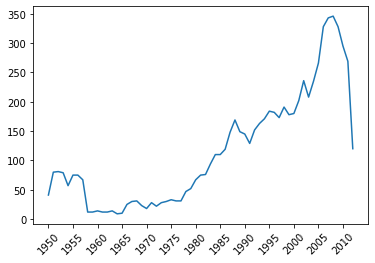

In [ ]:
plt.plot(year_count_df.year[30:], year_count_df[0][30:])
plt.xticks(np.arange(1950, 2015, 5), rotation = 45)
plt
plt.show()

There are some movies from very early days... The top one is definitely a mistake though.
These early movies could be quite different in plot and probably will only add noise to the data. To avoid this noise, it's better to look at the movies that were made when the industry already reached its maturity and got really into masses. Hence, I would only consider more recent movies, when it gets to  the movies starting from 1985.

In [ ]:
recent_df = year_count_df[year_count_df['year']>=1985]
recent_df

,year,0
65,1985,110
66,1986,119
67,1987,148
68,1988,169
69,1989,149
70,1990,145
71,1991,129
72,1992,152
73,1993,163
74,1994,171


In [ ]:
print('Recent movies N = ' + str(recent_df[0].sum()))

Recent movies N = 5719


##### *Exploring sample sizes for the top 3 genre: Drama, Comady, Thriller*

Checking the sample sizes per key genre could be useful if i want to take a topic modeling approach. Like in Berger & Packard (2018) paper: to get the originality measure, the topic distribution for a specific movie would be compared to an overall topic distribution for the genre it belongs to. This would only make sense, if I would have enough ovies of this genre.

In [ ]:
print('Total Drama: ' + str(movie.Drama.sum()))
print('Total Comedy: ' + str(movie.Comedy.sum()))
print('Total Thriller: ' + str(movie.Thriller.sum()))

Total Drama: 3901
Total Comedy: 2927
Total Thriller: 1857


In [ ]:
movie_recent = movie[movie.year >=1985]
print('From recent sample:')
print('Total Drama: ' + str(movie_recent.Drama.sum()))
print('Total Comedy: ' + str(movie_recent.Comedy.sum()))
print('Total Thriller: ' + str(movie_recent.Thriller.sum()))

From recent sample:
Total Drama: 2989
Total Comedy: 2388
Total Thriller: 1578


In [ ]:
movie_training_sample = movie_recent[movie_recent.year < 2009]
print('From training sample:')
print('Total Drama: ' + str(movie_training_sample.Drama.sum()))
print('Total Comedy: ' + str(movie_training_sample.Comedy.sum()))
print('Total Thriller: ' + str(movie_training_sample.Thriller.sum()))

From training sample:
Total Drama: 2441
Total Comedy: 2040
Total Thriller: 1290


In [ ]:
movie_predict_sample = movie_recent[(movie_recent.year >= 2009)&(movie_recent.year <= 2011)]
print('From prediction sample:')
print('Total Drama: ' + str(movie_predict_sample.Drama.sum()))
print('Total Comedy: ' + str(movie_predict_sample.Comedy.sum()))
print('Total Thriller: ' + str(movie_predict_sample.Thriller.sum()))

From prediction sample:
Total Drama: 500
Total Comedy: 311
Total Thriller: 257


### **Working with the Text**

In this section clean the text before putting it into tfidf. 
In the following I:
1. replace the 4-digit number with the word "year". If the year comes up in a plot it probably signals some hostoric event. I would like to preserve this signal, but drop the actual numbers, because they will not fly nicely when turning to tfidf matrix. 
2. Substitude meaning ful signs with words ($ and %). In the summaries these could be written both as words and as signs (depending on what the author decides), I would like to have them all in word format. 
3. Clean out puctuation. 
4. Remove named entities. Yes, named entities could carry some thematic meaning, but they could also do more harm than good. Reasoning: not everything that happens in New York or to a character named Mary has the same plot.
5. Conver to lower case.
6. Drop stop words.
7. Lemmatize. 

After cleaning I explore a bit (top words and most popular parts of speech). That could give me some indication of what (if anything) I may have messed up during the cleaning. 

In [ ]:
movie = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_semi_prep.csv')

In [ ]:
movie_sub = movie.drop(columns=['Unnamed: 0','release_date', 'run_time', 'languages', 'countries', 'genres',
       'english_lang', 'country_USA', 'Drama', 'Comedy', 'Thriller',
       'Romance Film', 'Action', 'Action/Adventure', 'Crime Fiction',
       'Adventure', 'Indie', 'Romantic comedy', 'Family Film', 'Horror',
       'Romantic drama', 'Fantasy', 'Mystery', 'year']).copy()

In [ ]:
movie_sub.head(15)

,wiki_movieID,summary,movie_name,box_of_rev
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,686533290.0
1,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,2300000.0
2,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0
3,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,49483352.0
4,24225279,"The story begins with Hannah, a young Jewish t...",Sing,2260616.0
5,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0
6,1480747,{{plot}} Following the sudden death of Kid's f...,House Party 2,19438638.0
7,447194,"Samson, a Hebrew placed under Nazirite vows fr...",Samson and Delilah,11000000.0
8,12978934,Beth Cappadora and her husband Pat experienc...,The Deep End of the Ocean,28121100.0
9,8471210,"In 1942, a 10 year old boy named Timmy plays w...",Pieces,2032311.0


**1. Replace year number with a year**

In [ ]:
movie_sub.summary = movie_sub.summary.str.replace('\d{4}', 'year')

In [ ]:
movie_sub.head(15)

,wiki_movieID,summary,movie_name,box_of_rev
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,686533290.0
1,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,2300000.0
2,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0
3,1952976,"{{plot}} The film opens in year, as a young gi...",Dark Water,49483352.0
4,24225279,"The story begins with Hannah, a young Jewish t...",Sing,2260616.0
5,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0
6,1480747,{{plot}} Following the sudden death of Kid's f...,House Party 2,19438638.0
7,447194,"Samson, a Hebrew placed under Nazirite vows fr...",Samson and Delilah,11000000.0
8,12978934,Beth Cappadora and her husband Pat experienc...,The Deep End of the Ocean,28121100.0
9,8471210,"In year, a 10 year old boy named Timmy plays w...",Pieces,2032311.0


**2. Substitute meaningful signs with words**

In [ ]:
movie_sub.summary = movie_sub.summary.str.replace('\$', 'dollar ')

In [ ]:
movie_sub.summary = movie_sub.summary.str.replace('%', ' percent')

**3. Punctuation and digits**

In [ ]:
repl_w_space = '[-/]' #replacing - and / with space
relp_wo_space = '(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\>)|(\<)|(\{)|(\})|(—)|(“)|(”)|(&)|(’)|(\*)' #replacing all other characters with nothing

In [ ]:
movie_sub.summary = movie_sub.summary.str.replace(repl_w_space, ' ')
movie_sub.summary = movie_sub.summary.str.replace(relp_wo_space, '')

In [ ]:
movie_sub.summary = movie_sub.summary.str.replace('\d+', '')

In [ ]:
movie_sub.head()

,wiki_movieID,summary,movie_name,box_of_rev
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,686533290.0
1,2231378,The Lemon Drop Kid a New York City swindler i...,The Lemon Drop Kid,2300000.0
2,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0
3,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0
4,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0


**4. Removing Named Entities** (incl. human names)

This has to come after the punctuation is removed, otherwise it crashes. 
Converting to lower case should come after this step, because the procedure is case-sensitive. Takes about 10 minutes.
Here just used the first that I found; an alternative is to use POS from nltk. 

In [ ]:
nlp = spacy.load('en_core_web_sm')


In [ ]:
no_entity_summary = []
for summary in movie_sub.summary:
  document = nlp(summary)
  entities = document.ents #get named entities tuple from the summary
  entities_list = []
  for entity in entities:
    entities_list.append(str(entity)) # neet to conver spacy.tokens.span.Span to string
  summary_new = summary
  if len(entities_list) == 0:
    no_entity_summary.append(summary_new)

  else:
    try:
      for str_entity in entities_list: #take each found entity
        summary_new = re.sub(str_entity, '', summary_new) #and substitude with nothing in the text
      no_entity_summary.append(summary_new)  #attach new text to a list
    except: # to skip over the error
      print('error at ' + str(len(no_entity_summary))) #it will tell you where the error is, so you can inspect
      no_entity_summary.append(summary) #attaches original text to the list, since it could not be processed


In [ ]:
movie_sub['summary_noname'] = no_entity_summary

In [ ]:
movie_sub.head()

,wiki_movieID,summary,movie_name,box_of_rev,summary_noname
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,686533290.0,The nation of consists of a wealthy and poo...
1,2231378,The Lemon Drop Kid a New York City swindler i...,The Lemon Drop Kid,2300000.0,The Lemon Drop a swindler is illegally tout...
2,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,pastor his wife their sons and their dau...
3,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,plot The film opens in as a young girl stand...
4,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,The story begins with a young teen as she is...


**5. Lower case**

In [ ]:
movie_sub.summary_noname = movie_sub.summary_noname.map(lambda x: x.lower())

**7.Removing Stop Words**

Uses punctuation, and works with lower case text. But I needed to remove punctuation and keep case information for named entities. Therefore, will clean out punctuation from the stop word list in the same way I did from the main text. An altenrative is to start with stop words earlier and use *.casefold()* on words for matching (it ignores the case). 

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stop_en = stopwords.words('english')
print(stop_en)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
relp_wo_space = '(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\>)|(\<)|(\{)|(\})|(—)|(“)|(”)|(&)|(’)|(\*)' #replacing all other characters with nothing

In [ ]:
stop_en2 = []
for stop in stop_en:
  stop2 = re.sub(relp_wo_space, '', stop)
  stop_en2.append(stop2)


In [ ]:
print(stop_en2)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

In [ ]:
stop_en2 = stop_en2 + ['plot']

In [ ]:
for stop in stop_en2:
  movie_sub.summary_noname = movie_sub.summary_noname.replace(to_replace=r'\b%s\b'%stop, value='', regex = True)

movie_sub.summary[5]

'Milan  Goran  two criminals  smuggle illegal immigrants One night   complete  smuggle  discover  one   immigrants  left  baby behind Milan  Goran decide  sell  baby  Lubos  Eman   responsible  running  illegal baby adoption center Lubos  Eman make attempts  sell  baby  Miluska  Frantisek  barren couple Concurrently  university professor  diagnosed   inoperable brain tumor setting  action  complicated train  family reunions partings  conflicts'

In [ ]:
movie_sub.summary_noname[5]

'     criminals  smuggle illegal immigrants    complete  smuggle  discover     immigrants  left  baby behind    decide  sell  baby       responsible  running  illegal baby adoption center    make attempts  sell  baby      barren couple concurrently  university professor  diagnosed   inoperable brain tumor setting  action  complicated train  family reunions partings  conflicts'

In [ ]:
movie_sub.summary_noname = movie_sub.summary_noname.str.replace('\s+', ' ') #substitute multiple white spaces with just one

In [ ]:
movie_sub.summary_noname[5]

'criminals smuggle illegal immigrants complete smuggle discover immigrants left baby behind decide sell baby responsible running illegal baby adoption center make attempts sell baby barren couple concurrently university professor diagnosed inoperable brain tumor setting action complicated train family reunions partings conflicts'

**7. Lemmatize**

In [ ]:
wnl = nltk.WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
lemmatized_texts = []
for text in movie_sub.summary_noname: #take a text
  tokenized_words = word_tokenize(text) #split it into a list of words
  lemmatized_words = [] #empty list for new words
  for word in tokenized_words:#for each othe these words
    lem_word = wnl.lemmatize(word)#create a lemma
    lemmatized_words.append(lem_word) #append it to the new list of words
  new_text = " ".join(lemmatized_words) # join words from list into one object
  lemmatized_texts.append(new_text) #add to the new list with texts

In [ ]:
movie_sub['summary_lemmas'] = lemmatized_texts

In [ ]:
movie_sub.head()

,wiki_movieID,summary,movie_name,box_of_rev,summary_noname,summary_lemmas
0,31186339,The nation Panem consists wealthy Capitol ...,The Hunger Games,686533290.0,nation consists wealthy poorer districts punis...,nation consists wealthy poorer district punish...
1,2231378,The Lemon Drop Kid New York City swindler i...,The Lemon Drop Kid,2300000.0,lemon drop swindler illegally touting horses r...,lemon drop swindler illegally touting horse ra...
2,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,pastor wife sons daughter camping holiday fami...,pastor wife son daughter camping holiday famil...
3,1952976,plot The film opens year young girl Dahlia ...,Dark Water,49483352.0,film opens young girl stands outside school ra...,film open young girl stand outside school rain...
4,24225279,The story begins Hannah young Jewish teen ...,Sing,2260616.0,story begins young teen completing senior year...,story begin young teen completing senior year ...


In [ ]:
#saving
movie_sub.to_csv('movies2012_text_clean.csv')

!cp movies2012_text_clean.csv "/content/drive/MyDrive/movies2012data"

**8. Get Top Words**

Approaching manually trhough tokenization. An alternative approach is to use *FreqDist* from *nltk*.

In [ ]:
movie_sub = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_text_clean.csv')

In [ ]:
#creating a list of all words
all_words = []
for text in movie_sub.summary_lemmas: #take a text
  try:
    tokenized_words = word_tokenize(text) #split it into a list of word
    all_words = all_words + tokenized_words
  except:
    print(text)  

nan


In [ ]:
all_words = np.array(all_words) #turning into numpay array

value, counts = np.unique(all_words, return_counts=True)
summary_df = pd.DataFrame({'word': value,
                           'frequency': counts})

In [ ]:
summary_df = summary_df.sort_values('frequency', ascending=False)
summary_df.head(20)

,word,frequency
13132,find,9413
14776,go,7938
34532,take,7377
34834,tell,7304
14568,get,7290
2432,back,7177
12749,father,5867
20051,life,5673
13995,friend,5627
35338,time,5474


In [ ]:
len(summary_df) #got 39.5k unique words

39574

This top is interesting. Usually nouns are the most common part of speech in a text. Here no noun made it to top 5. I could be that nouns are more diverse and if I do parts of speech tagging, it will get on top. Or it could be that because the movie plots are about what happened, verbs play a more important role than nouns would do. I'll have a look which one it is.

In [ ]:
print(len(summary_df[summary_df.frequency==1]))
print('percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency==1]))/len(summary_df)))

14320
percent drop to 0.6381462576439076


In [ ]:
print(len(summary_df[summary_df.frequency<=5]))
print('percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency<=5]))/len(summary_df)))

24885
percent drop to 0.3711780461919442


In [ ]:
print(len(summary_df[summary_df.frequency<=10]))
print('percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency<=10]))/len(summary_df)))

28774
percent drop to 0.2729064537322484


In [ ]:
print(len(summary_df[summary_df.frequency>10]))

10800


In [ ]:
print(len(summary_df[summary_df.frequency<=50]))
print('percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency<=50]))/len(summary_df)))

35175
percent drop to 0.1111588416637186


**9.Parts of speech check**

Some reccomend to tag the words before lemmatizing them, and the feeding the tag into the lemmatizer. This way lemmatization is a bit more accurate. That's nore of a note for future cleaning. Will not do that here. 

In [ ]:
movie_data = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_text_clean.csv')

In [ ]:
movie_data.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,box_of_rev,summary_noname,summary_lemmas
0,0,31186339,The nation Panem consists wealthy Capitol ...,The Hunger Games,686533290.0,nation consists wealthy poorer districts punis...,nation consists wealthy poorer district punish...
1,1,2231378,The Lemon Drop Kid New York City swindler i...,The Lemon Drop Kid,2300000.0,lemon drop swindler illegally touting horses r...,lemon drop swindler illegally touting horse ra...
2,2,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,pastor wife sons daughter camping holiday fami...,pastor wife son daughter camping holiday famil...
3,3,1952976,plot The film opens year young girl Dahlia ...,Dark Water,49483352.0,film opens young girl stands outside school ra...,film open young girl stand outside school rain...
4,4,24225279,The story begins Hannah young Jewish teen ...,Sing,2260616.0,story begins young teen completing senior year...,story begin young teen completing senior year ...


In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# tokeinse each text 
pos = []
for summary in movie_data.summary_lemmas:
  try:
    tokenized = word_tokenize(summary)
    tuple_tagged = nltk.pos_tag(tokenized) # pos tag each text
    for word in tuple_tagged:
      pos.append(word[1]) # add parts of speech to list
  except:
    print('this did not work ' + str(summary))    

pos = np.array(pos) # convert list 2 to numpy array and get df with parts and counts
part, count = np.unique(pos, return_counts=True)
pos_df = pd.DataFrame({'pos': part,
                       'frequency': count})

pos_df = pos_df.sort_values('frequency', ascending=False)

pos_df.head(10)

this did not work nan


,pos,frequency
13,NN,722869
9,JJ,275982
19,RB,107379
28,VBG,104669
30,VBP,76082
27,VBD,72646
15,NNS,55059
26,VB,53378
29,VBN,51055
31,VBZ,36110


So far noun is leading. However, it looks like there is quite a bit of different verb variations. I need to collapse them into one.

In [ ]:
pos_new = []
for p in pos:
  if bool(re.match('VB.', p)):
    pos_new.append(re.sub('VB.', 'VB', p))
  else:
    pos_new.append(p)  



In [ ]:
pos_new = np.array(pos_new) # convert list 2 to numpy array and get df with parts and counts
part, count = np.unique(pos_new, return_counts=True)
pos_df = pd.DataFrame({'pos': part,
                       'frequency': count})

pos_df = pos_df.sort_values('frequency', ascending=False)

pos_df.head(10)

,pos,frequency
13,NN,722869
26,VB,393940
9,JJ,275982
19,RB,107379
15,NNS,55059
8,IN,29991
12,MD,7217
10,JJR,5796
20,RBR,4175
5,DT,4069


Noun is still the top POS. Hence, it is the higher diversity of the words that makes specific verbs lead in the frequency. 

**10. Degenerative case: One empty text**

In [ ]:
movie_data.summary_lemmas[683]

nan

In [ ]:
movie_data.summary[683]

'Holly Marie Combs  Diane Zamora David Lipper  David Graham Cassidy Rae  Adrienne Jones Dee Wallace  Mrs Jones'

OK, now the data seems clean enough and ready for analysis. 